## Differentially accessibility analysis
**Note:** Portions of the code were adapted from the [Signac vignettes](https://stuartlab.org/signac/articles/overview).

In [1]:

# Install required packages if not already installed
if (!requireNamespace("Seurat", quietly = TRUE)) {
    install.packages("Seurat")
}

if (!requireNamespace("Signac", quietly = TRUE)) {
    install.packages("Signac")
}

# install presto for an extremely fast implementation of Wilcoxon test 
install.packages("devtools")
devtools::install_github("immunogenomics/presto")


if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("clusterProfiler", quietly = TRUE)) {
    BiocManager::install("clusterProfiler")
}

if (!requireNamespace("org.Hs.eg.db", quietly = TRUE)) {
    BiocManager::install("org.Hs.eg.db")
}

if (!requireNamespace("enrichplot", quietly = TRUE)) {
    BiocManager::install("enrichplot")
}

if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

if (!requireNamespace("ggplot2", quietly = TRUE)) {
    install.packages("ggplot2")
}

if (!requireNamespace("patchwork", quietly = TRUE)) {
    install.packages("patchwork")
}


suppressPackageStartupMessages({
    suppressWarnings({
        library(Seurat)
        library(Signac)

        library(clusterProfiler)
        library(org.Hs.eg.db)
        library(enrichplot)
        
        library(dplyr)
        
        library(ggplot2)
        library(patchwork)
    })
})



Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Skipping install of 'presto' from a github remote, the SHA1 (7636b3d0) has not changed since last install.
  Use `force = TRUE` to force installation







### 1. What are DAR and DA analysis?

**Differentially accessible regions/peaks** (DAR) are genomic regions that show significant differences in chromatin accessibility between cell groups or conditions.

**Differentially accessibility** (DA) analysis in ATAC-seq identifies peaks that are more open (accessible) or closed (inaccessible) in one cell population/cell type compared to another. This allows us to uncover regulatory elements that may be active in specific cell types or states.



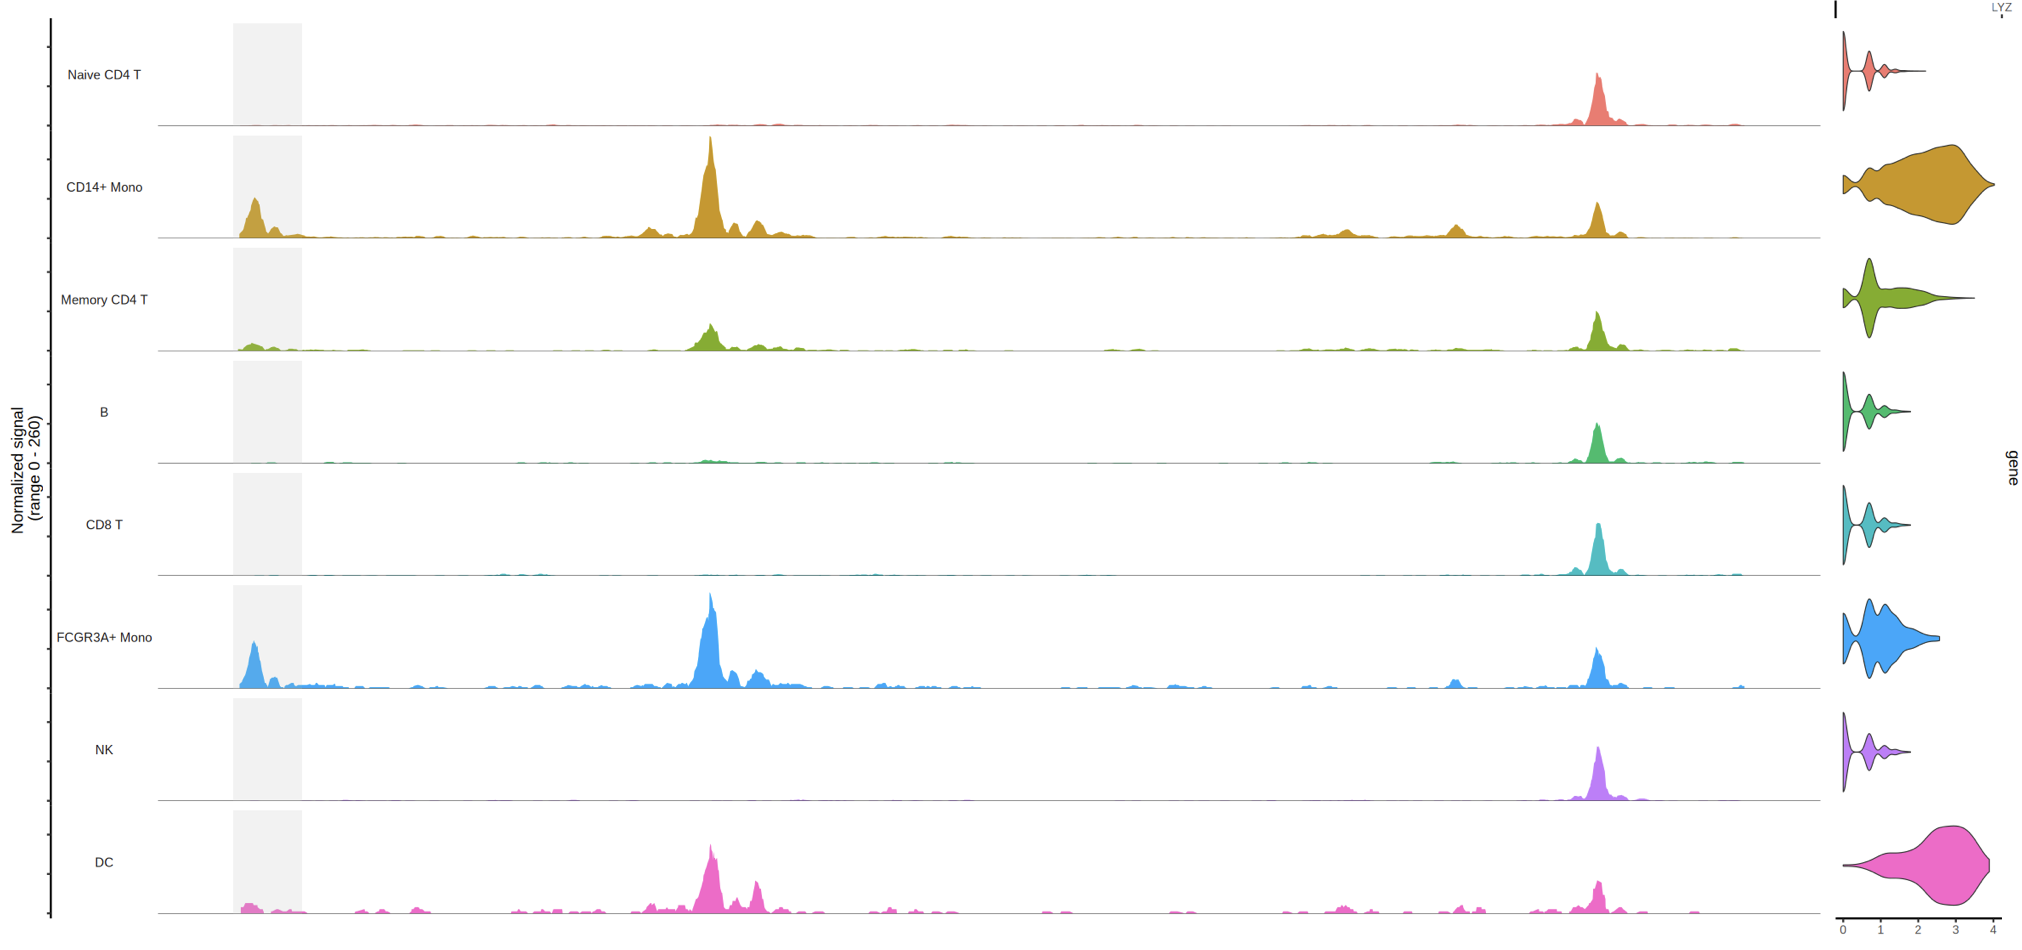

### 2. Methods for DA analysis


*Single cell* (Differential expression - DE; differential accessbility - DA)

- Wilcoxon Rank-Sum test (DE/DA)
- Likelihood ratio test (DE)
- Student's t-test (DE/DA)
- Negative binomial linear model (DE/DA)
- Logistic regression (DE/DA)
- MAST (DE)
- Fisher exact test (DA)
- Binomial test (DA)
- Logistic regression based on peaks (DA)
- Permutation test (DA)

*Pseudobulk*

- edgeR-LRT
- edgeR-QLF
- DESeq2-LRT
- DESeq2-Wald
- limma-trend
- limma-voom

*Mixed model*

- Linear mixed model
- Linear mixed model-LRT
- Negative binomial generalized linear mixed model
- Negative binomial generalized linear mixed model-LRT
- Negative binomial generalized linear mixed model with offset
- Negative binomial generalized linear mixed model with offset-LRT
- Poisson generalized linear mixed model
- Poisson generalized linear mixed model-LRT
- Poisson generalized linear mixed model with offset
- Poisson generalized linear mixed model with offset-LRT

*SnapATAC `findDAR` method*

The pseudobulk methods (`DESeq2`, `edgeR`, `limma`) usually have the best performance in term of accuracy.

Refer to [Teo et al., *Nature Communication*, 2024](https://doi.org/10.1038/s41467-024-53089-5) and the Libra[]() package for additional information.

Below, we will use the Wilcoxon rank sum test.


##### Load the joint RNA-seq/ATAC-seq Seurat object

In [2]:
# multi_merged <- readRDS("../data/PBMC.joint.rds")
multi_merged <- readRDS("PBMC.joint.rds")
multi_merged

An object of class Seurat 
418325 features across 17214 samples within 3 assays 
Active assay: SCT (24383 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, ATAC
 6 dimensional reductions calculated: pca, harmony_rna, umap, atac.integrated_lsi, atac.umap, wnn.umap

##### Set the annotated cell type as Idents of the Seurat

In [3]:
Idents(multi_merged) <- multi_merged@meta.data$annot_cell_type

##### We performed DA analysis between cell clusters/cell types using `FindMarkers()` function in Seurat.

Notable arguments:
- `ident.1`: Identity class for 1st group of cells
- `ident.2`: Identity class for 2nd group of cells
- `test.use`: Statistical test for 
    - "wilcox": Wilcoxon test
    - "t": Student's t-test
    - "negbinom": Negative binomial generalized linear model
    - "poisson": Poisson generalized linear model
    - "LR": Logistic regression model
    - "DESeq2": pseudobulk using DESeq2
    - etc
- `min.pct`: only test genes that are detected in a minimum fraction of `min.pct` cells in either of the two groups. Meant to speed up the function by not testing genes that are very infrequently expressed.

In [4]:
# change back to working with peaks instead of gene activities
DefaultAssay(multi_merged) <- "ATAC"

# wilcox is the default option for test.use
da_peaks <- FindMarkers(
  object = multi_merged,
  ident.1 = "B",
  ident.2 = "CD14+ Mono",
  test.use = 'wilcox',
  min.pct = 0.1
)


`FindMarkers()` function returns a dataframe, containing:
- `rownames`: peak name
- `avg_log2FC`: average $\log_2$ fold change of the peak in the 1st group of cells compared to the 2nd group of cells
    - If > 0: peak is more accessible (open) in the 1st group
    - If < 0: peak is more accessible (open) in the 2nd group
- `pct.1`: percentage of cells in 1st group where the peak is open
- `pct.2`: percentage of cells in 2nd group where the peak is open
- `p_val`: p-value
- `p_val_adj`: adjusted p-value

In [5]:
da_peaks |> head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr13-74133711-74134604,0,4.945839,0.719,0.032,0
chr12-119988558-119989458,0,5.080457,0.598,0.024,0
chr19-5130188-5131107,0,5.046440,0.569,0.020,0
chr20-57398040-57398895,0,3.766503,0.607,0.058,0
chr6-167113879-167114832,0,6.779112,0.540,0.006,0
chr9-37408873-37409819,0,6.243489,0.540,0.008,0


Let's look at the first peak. 

A positive `avg_log2FC` implies that the peak is more accessible in B cells compared to CD14+ monocytes.

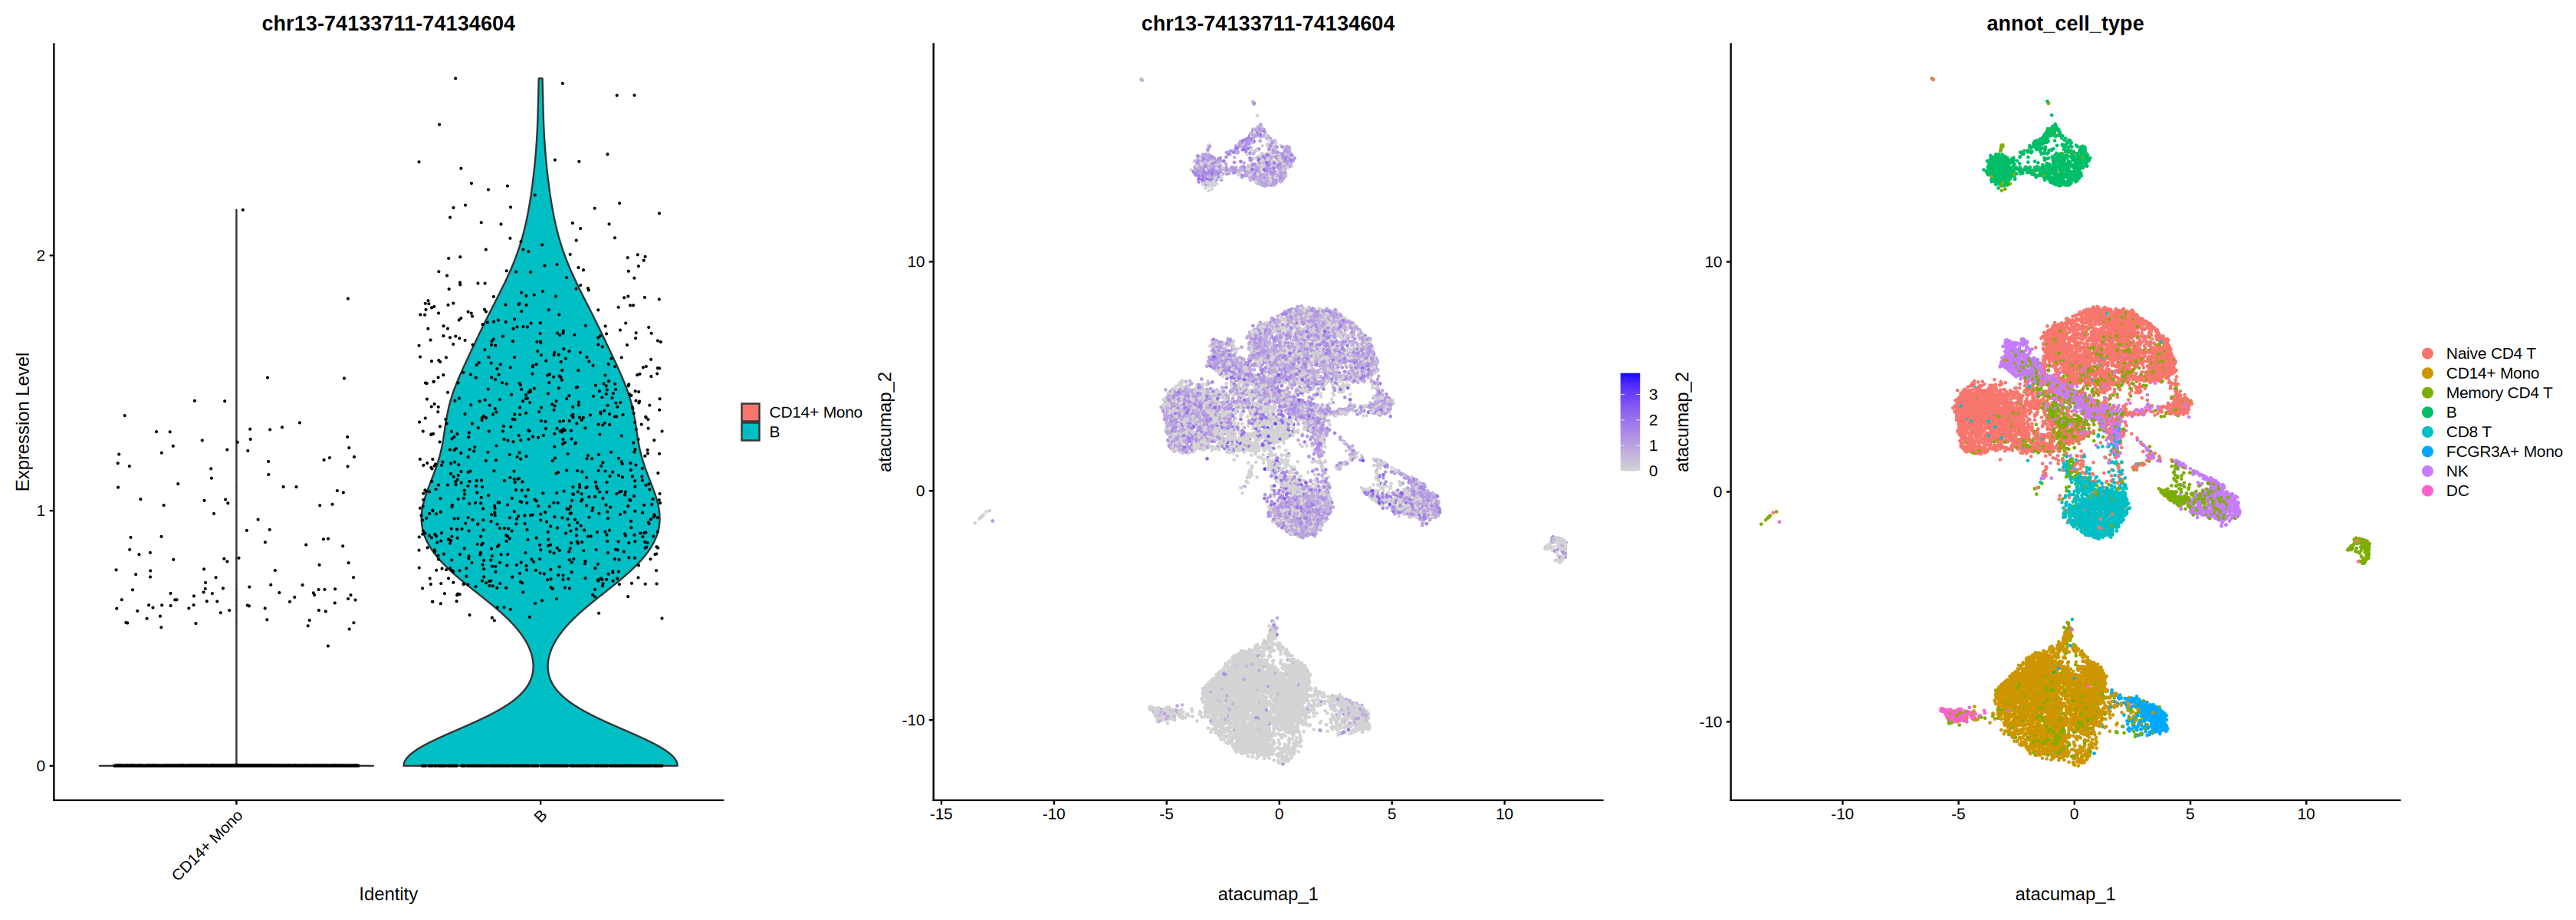

In [6]:

plot1 <- VlnPlot(
    object = multi_merged,
    features = rownames(da_peaks)[1],
    pt.size = 0.1,
    idents = c("B", "CD14+ Mono")
)

plot2 <- FeaturePlot(
    object = multi_merged,
    features = rownames(da_peaks)[1],
    pt.size = 0.1
)

plot3 <- DimPlot(
    multi_merged, 
    reduction = "atac.umap", 
    group.by = "annot_cell_type", 
    repel = TRUE
)

options(repr.plot.width = 28, repr.plot.height = 10)
plot1 | plot2 | plot3


From the `FeaturePlot`, we noticed that the peak is closed in monocytes, open in B cells and T cells.


Let's try to visualize the chromatin accessibility of another DA peak, but in CD14+ monocytes ($\text{avg\_log2FC} < 0$).

In [7]:
neg_da_peaks <- da_peaks |> filter(avg_log2FC < 0)
neg_da_peaks |> head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6-44058435-44059439,3.734166e-276,-6.697048,0.007,0.622,4.868643e-271
chr19-703567-704496,1.989550e-243,-3.988892,0.049,0.618,2.593995e-238
chr17-78442410-78443327,3.720877e-232,-7.478921,0.003,0.551,4.851317e-227
chr20-50274643-50275568,6.883457e-226,-7.338826,0.004,0.541,8.974721e-221
chr9-134371489-134372353,2.661730e-218,-5.735363,0.012,0.538,3.470390e-213
chr9-129776905-129777828,7.179451e-217,-5.722604,0.010,0.537,9.360639e-212


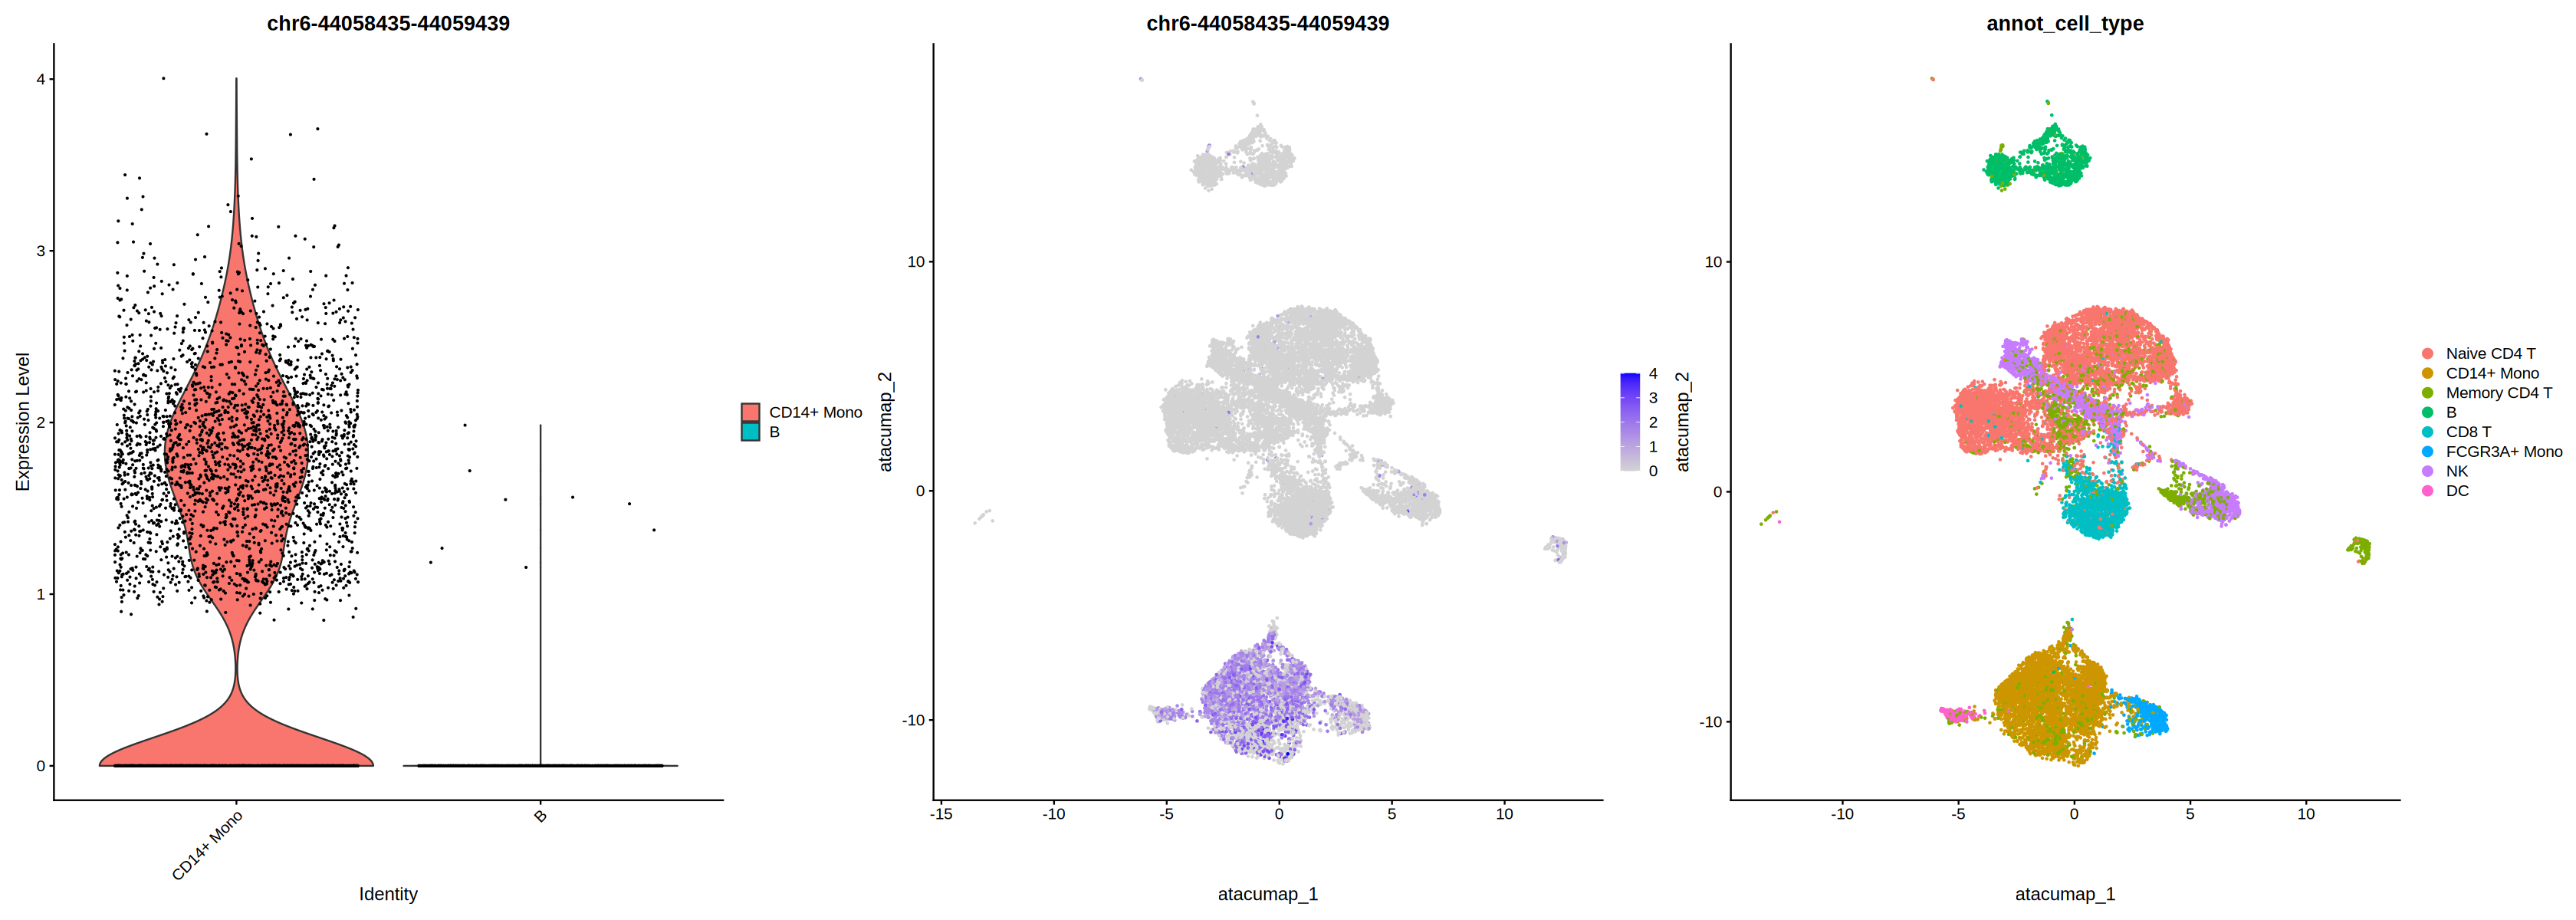

In [8]:

plot1 <- VlnPlot(
    object = multi_merged,
    features = rownames(neg_da_peaks)[1],
    pt.size = 0.1,
    idents = c("B", "CD14+ Mono")
)

plot2 <- FeaturePlot(
    object = multi_merged,
    features = rownames(neg_da_peaks)[1],
    pt.size = 0.1
)

plot3 <- DimPlot(
    multi_merged, 
    reduction = "atac.umap", 
    group.by = "annot_cell_type", 
    repel = TRUE
)

options(repr.plot.width = 28, repr.plot.height = 10)
plot1 | plot2 | plot3


What if we want to find peaks that are *exclusively* open in B cells?

We set `ident.2` to NULL. By default, the function will compare chromatin accessibility of peaks in B cells to **all other cells**.

In [9]:
# wilcox is the default option for test.use
bcell_da_peaks <- FindMarkers(
  object = multi_merged,
  ident.1 = "B",
  ident.2 = NULL,
  test.use = 'wilcox',
  min.pct = 0.1
)

bcell_da_peaks |> head()


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr16-88045638-88046576,0,4.347947,0.563,0.031,0
chr10-48671212-48672151,0,6.933673,0.531,0.005,0
chr2-231672358-231673238,0,4.983938,0.537,0.019,0
chr14-64235492-64236423,0,6.118097,0.513,0.008,0
chr22-41935930-41936869,0,4.843522,0.519,0.019,0
chr9-37408873-37409819,0,3.677754,0.540,0.045,0


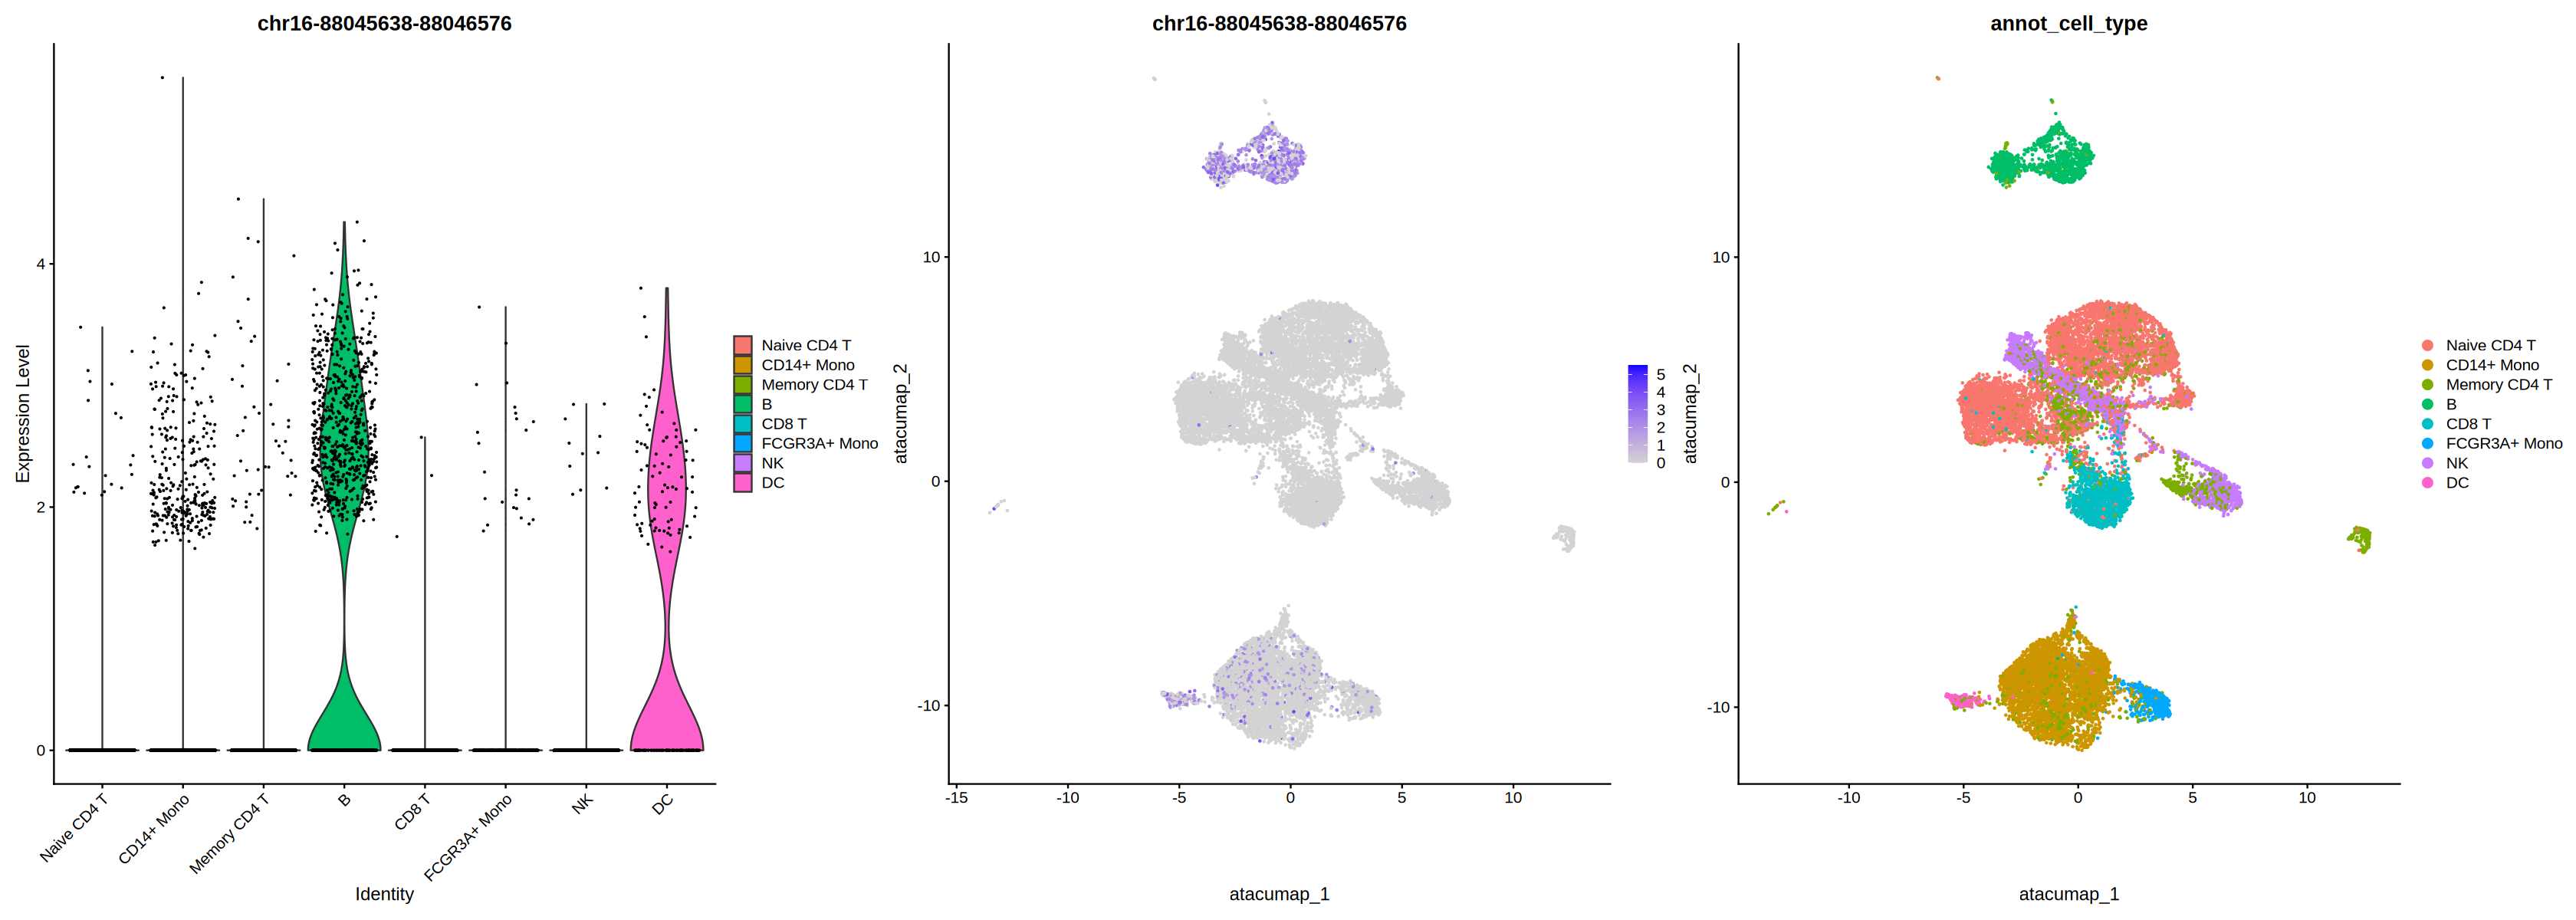

In [10]:

plot4 <- VlnPlot(
    object = multi_merged,
    features = rownames(bcell_da_peaks)[1],
    pt.size = 0.1
)

plot5 <- FeaturePlot(
    object = multi_merged,
    features = rownames(bcell_da_peaks)[1],
    pt.size = 0.1
)

plot6 <- DimPlot(
    multi_merged, 
    reduction = "atac.umap", 
    group.by = "annot_cell_type", 
    repel = TRUE
)

options(repr.plot.width = 28, repr.plot.height = 10)
plot4 | plot5 | plot6


This time we found peaks that are (almost) exclusively open in B cells.

### 3. Validation of DA results

To interpret DA peaks, we look for the closest gene to each peak. These are likely the genes that the open chromatin peaks regulate.

We collect the names of these nearby genes and run a Gene Ontology (GO) analysis. GO analysis groups genes based on their shared biological functions, cellular locations, or molecular activities — helping us understand the broader meaning, or "semantic context", of the gene set. In short, this tells us what kinds of functions those genes are involved in.

If the results show functions that match what the cell type does, it supports that the DA peaks are meaningful.

#### Step 1. Link DA peaks to their closests genes

First, we identified DA peaks in B cell and CD14+ monocytes, respectively.

In [11]:
open_bcell <- rownames(da_peaks[da_peaks$avg_log2FC > 3, ])
open_cd14mono <- rownames(da_peaks[da_peaks$avg_log2FC < -3, ])

We use `ClosestFeature()` function in `Signac` to find the closest genes to each DA peaks.

In [12]:

closest_genes_bcell <- ClosestFeature(multi_merged, regions = open_bcell)
closest_genes_bcell |> head()

closest_genes_cd14mono <- ClosestFeature(multi_merged, regions = open_cd14mono)
closest_genes_cd14mono |> head()

,tx_id,gene_name,gene_id,gene_biotype,type,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
ENSE00001893978,ENST00000472022,KLF12,ENSG00000118922,protein_coding,exon,chr13-73994990-73995056,chr13-74133711-74134604,138654
ENSE00002206071,ENST00000397558,BICDL1,ENSG00000135127,protein_coding,exon,chr12-119989869-119990297,chr12-119988558-119989458,410
ENST00000611640,ENST00000611640,KDM4B,ENSG00000127663,protein_coding,cds,chr19-5131076-5131545,chr19-5130188-5131107,0
ENST00000440234,ENST00000440234,RBM38,ENSG00000132819,protein_coding,gap,chr20-57392778-57407542,chr20-57398040-57398895,0
ENST00000646493,ENST00000646493,CCR6,ENSG00000112486,protein_coding,gap,chr6-167112015-167136037,chr6-167113879-167114832,0
ENSE00001830552,ENST00000493368,GRHPR,ENSG00000137106,protein_coding,exon,chr9-37422666-37422805,chr9-37408873-37409819,12846


,tx_id,gene_name,gene_id,gene_biotype,type,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
ENST00000336600,ENST00000336600,C6orf223,ENSG00000181577,protein_coding,utr,chr6-44003127-44007612,chr6-44058435-44059439,50822
ENSE00002843176,ENST00000338448,PALM,ENSG00000099864,protein_coding,exon,chr19-708935-709151,chr19-703567-704496,4438
ENST00000591369,ENST00000591369,DNAH17,ENSG00000187775,protein_coding,gap,chr17-78441200-78444603,chr17-78442410-78443327,0
ENST00000303004,ENST00000303004,CEBPB,ENSG00000172216,protein_coding,utr,chr20-50192072-50192668,chr20-50274643-50275568,81974
ENST00000484822,ENST00000484822,RXRA,ENSG00000186350,protein_coding,gap,chr9-134319485-134401631,chr9-134371489-134372353,0
ENSE00001389095,ENST00000340607,PTGES,ENSG00000148344,protein_coding,exon,chr9-129752887-129753042,chr9-129776905-129777828,23862


#### Step 2. Perform Gene Ontology analysis on the list of nearest genes

Next, we perform GO analysis using `enrichGO()` function from the `clusterProfiler` library.

Arguments:
- `gene`: gene list
- `keytype`: keytype of input genes (Ensembl, Entrez)
- `ont`: subontologies (BP = *Biological Process*, MF = *Molecular Function*, CC = *Cellular Component*, or ALL)
- etc

We can visualize GO results using `barplot()` function from the `enrichplot` library.
  

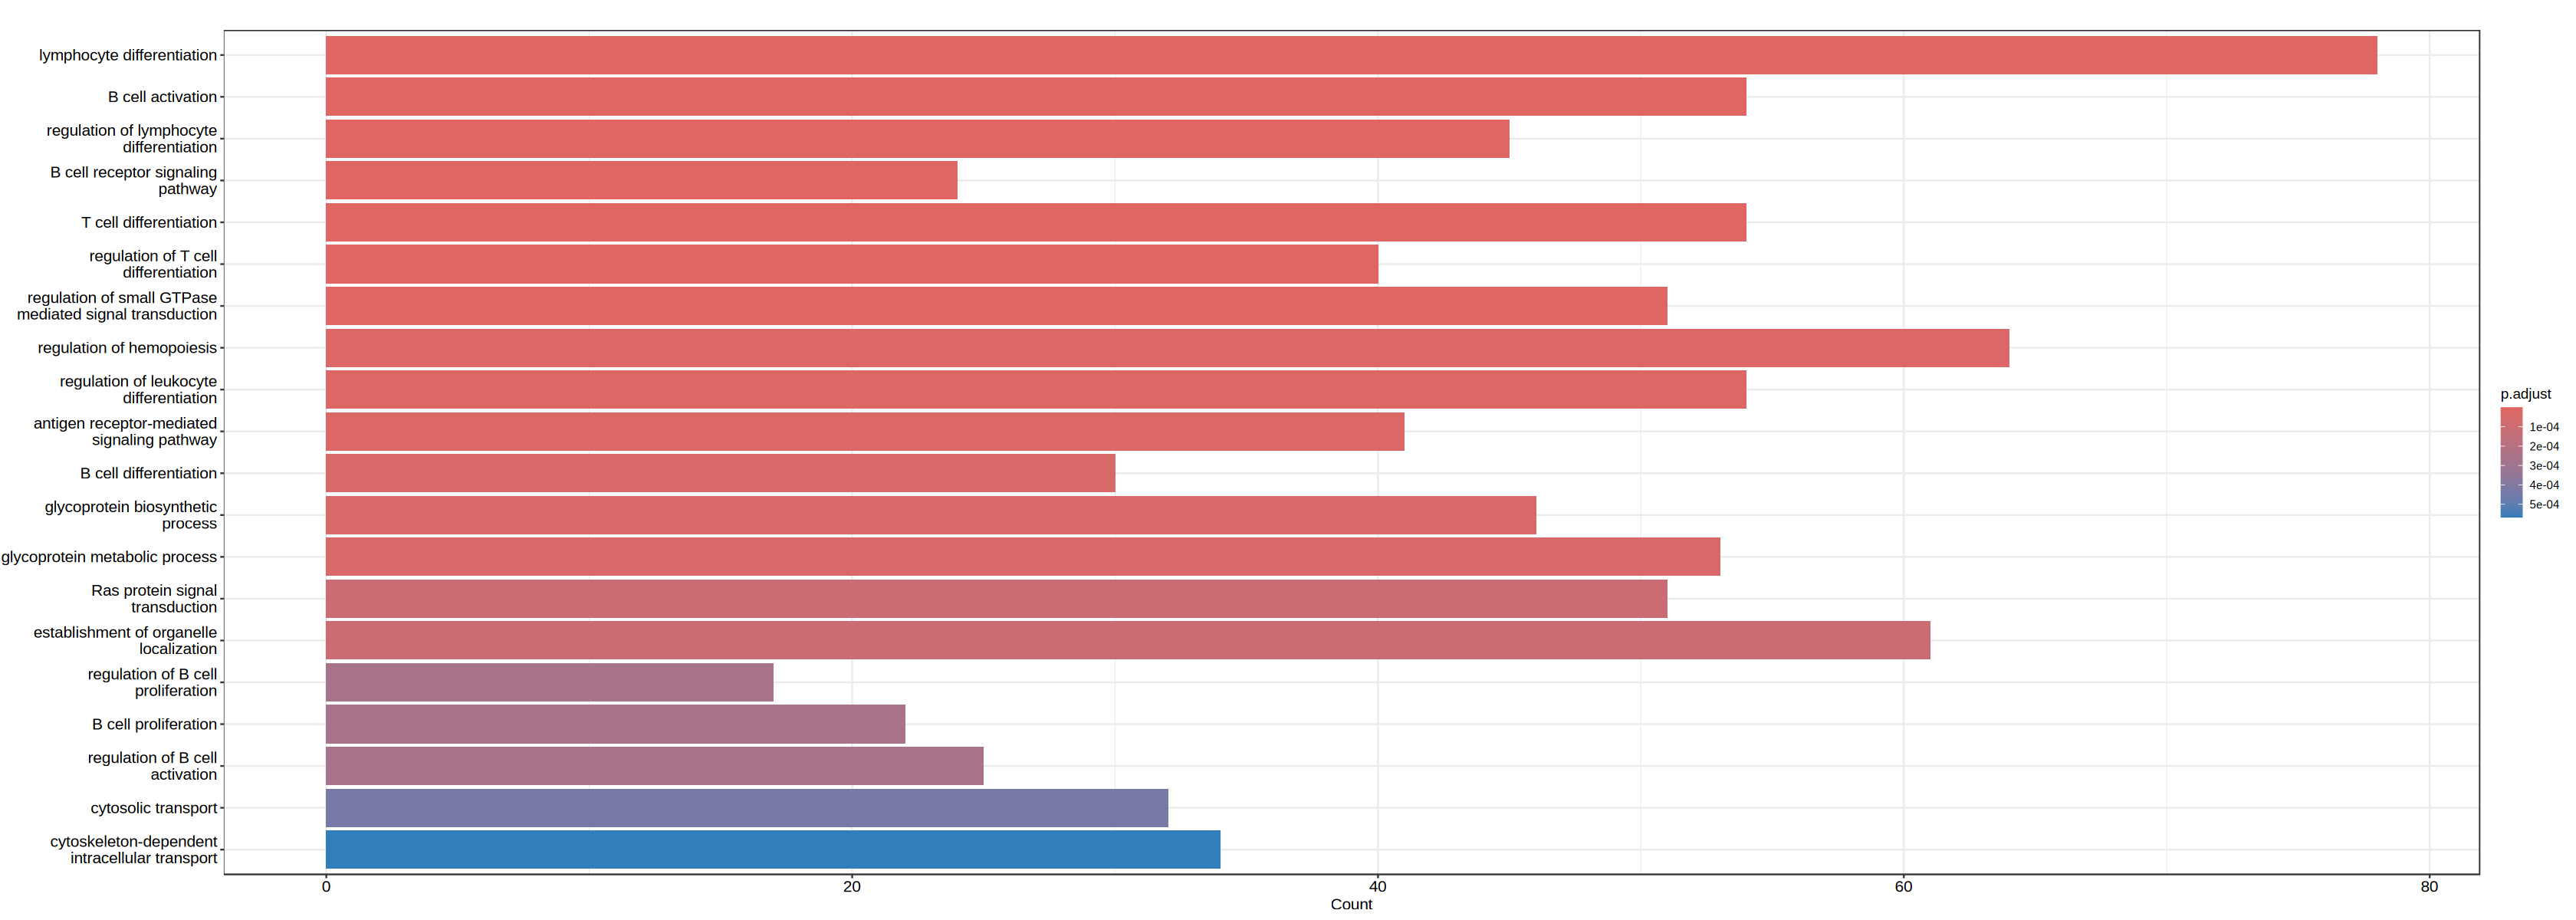

In [13]:
bcell_ego <- enrichGO(gene = closest_genes_bcell$gene_id,
                keyType = "ENSEMBL",
                OrgDb = org.Hs.eg.db,
                ont = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff = 0.05,
                qvalueCutoff = 0.05,
                readable = TRUE)

barplot(bcell_ego, showCategory = 20)


GO analysis for B cells showed upregulated process relevant to lymphoid leukocytes and B cells.

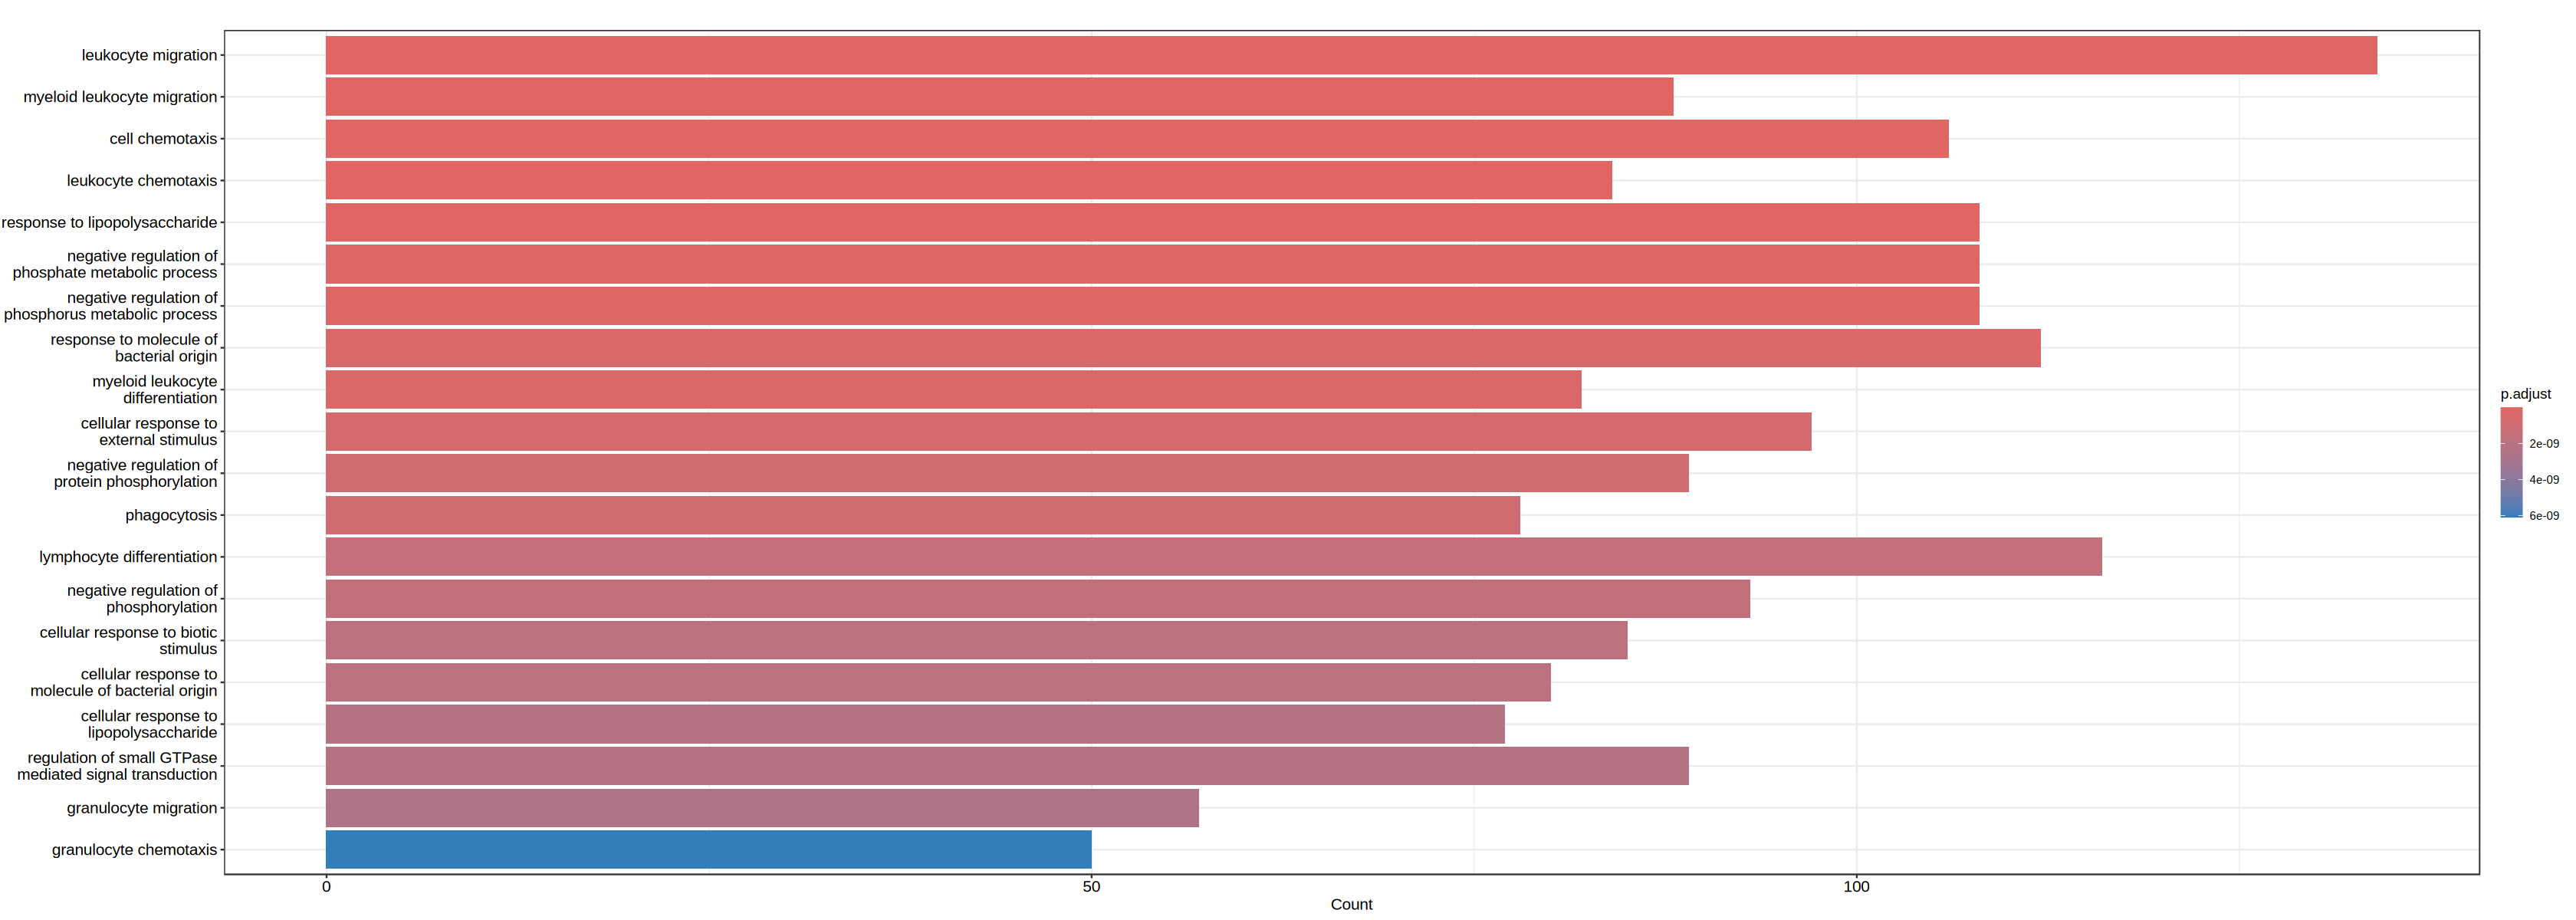

In [14]:

cd14mono_ego <- enrichGO(gene = closest_genes_cd14mono$gene_id,
                keyType = "ENSEMBL",
                OrgDb = org.Hs.eg.db,
                ont = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff = 0.05,
                qvalueCutoff = 0.05,
                readable = TRUE)

barplot(cd14mono_ego, showCategory = 20)


GO analysis for Cd14+ monocytes showed upregulated processes relevant to myeloid leukocytes and phagocytosis.

In [15]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.10 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /home/ch260976/.conda/envs/jlab/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.3.0        ggplot2_3.5.1          dplyr_1.1.4           
 [4] enrichplot_1.22.0      org.Hs.eg.db_3.18.0    AnnotationDbi_1.64.1  
 [7] IRanges_2.36.0         S4Vectors_0.40.2    